In [13]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
import pandas as pd
from glob import glob
from IPython.core.display import Image, display
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline

from sklearn.metrics import classification_report

from keras import models, layers, optimizers
from keras.preprocessing import image
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint
from tqdm import tqdm
import math
import pickle
import os
from PIL import ImageFile
import time

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
# from keras.callbacks import TensorBoard

In [2]:
# Add GPU options
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.333)
sess = tf.Session(config = tf.ConfigProto(gpu_options = gpu_options))
NAME = 'Binary_chest_cnn_64x3_{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))
#tensorboard --logdir=logs/ --host localhost --port 8088

# Information

In [31]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    """Returns the path and the Label from the folder"""
    data = load_files(path)
    chest_files = np.array(data['filenames'])
    chest_targets = np_utils.to_categorical(np.array(data['target']), 2)
    return chest_files, chest_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('../imgs/images/train')
test_files, test_targets = load_dataset('../imgs/images/test')

# load list of dog names
labels = [item[21:-1] for item in sorted(glob("../imgs/images/train/*/"))]

print('Statistics about the Dataset:\n')
print('There are %d total chest deseases.' % len(labels))
print('There are %s total chest images.\n' % len(np.hstack([train_files, test_files])))
print('There are %d training chest images.' % len(train_files))
# print('There are %d validation dog images.' % len(valid_files))
print('There are %d test chest images.'% len(test_files))

Statistics about the Dataset:

There are 2 total chest deseases.
There are 4999 total chest images.

There are 4032 training chest images.
There are 967 test chest images.


In [5]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [6]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 967/967 [00:19<00:00, 50.79it/s]


In [7]:
train_tensors.shape, train_targets.shape

((4032, 224, 224, 3), (4032, 2))

In [8]:
model = Sequential()
model.add( Conv2D(64, (3, 3), input_shape = train_tensors.shape[1:]) )
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

# model.add(GlobalAveragePooling2D(input_shape=(train_tensors.shape[1:])))

#---------------------------------------
model.add(layers.Dense(64))
model.add(layers.Dense(2))
model.add(layers.Activation('softmax'))
#----------------------------------------

# model.add(layers.Dense(256))
# model.add(layers.BatchNormalization())
# model.add(layers.Activation('relu'))
# model.add(layers.Dropout(0.5))

# model.add(layers.Dense(2))
# model.add(layers.BatchNormalization())
# model.add(layers.Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 64)      1792      
_________________________________________________________________
activation_1 (Activation)    (None, 222, 222, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
activation_2 (Activation)    (None, 109, 109, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 186624)            0         
__________

### New model

In [9]:
model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
History = model.fit(train_tensors, train_targets, validation_split = 0.2,
          epochs=2, batch_size=32, verbose=1, shuffle=True) #callbacks=[tensorboard]

Train on 3225 samples, validate on 807 samples
Epoch 1/2
3225/3225 [==============================] - ETA: 10:53 - loss: 0.7121 - acc: 0.53 - ETA: 9:44 - loss: 4.1131 - acc: 0.5312 - ETA: 9:09 - loss: 5.4138 - acc: 0.520 - ETA: 8:43 - loss: 5.4379 - acc: 0.554 - ETA: 8:47 - loss: 5.8532 - acc: 0.550 - ETA: 8:38 - loss: 6.2135 - acc: 0.541 - ETA: 8:27 - loss: 6.1131 - acc: 0.558 - ETA: 8:27 - loss: 5.9751 - acc: 0.574 - ETA: 8:24 - loss: 6.1461 - acc: 0.569 - ETA: 8:21 - loss: 5.9824 - acc: 0.584 - ETA: 8:32 - loss: 5.8939 - acc: 0.593 - ETA: 8:27 - loss: 5.9037 - acc: 0.596 - ETA: 8:28 - loss: 5.9120 - acc: 0.598 - ETA: 8:41 - loss: 5.9906 - acc: 0.596 - ETA: 8:34 - loss: 6.1256 - acc: 0.589 - ETA: 8:32 - loss: 6.0558 - acc: 0.595 - ETA: 8:23 - loss: 5.9648 - acc: 0.602 - ETA: 8:18 - loss: 6.0509 - acc: 0.599 - ETA: 8:13 - loss: 6.1015 - acc: 0.597 - ETA: 8:05 - loss: 6.0970 - acc: 0.598 - ETA: 8:00 - loss: 6.1645 - acc: 0.595 - ETA: 7:53 - loss: 6.2486 - acc: 0.590 - ETA: 7:50 - loss:

3225/3225 [==============================] - ETA: 10:28 - loss: 7.5142 - acc: 0.53 - ETA: 10:44 - loss: 6.5123 - acc: 0.59 - ETA: 10:13 - loss: 6.3453 - acc: 0.60 - ETA: 10:34 - loss: 6.5123 - acc: 0.59 - ETA: 10:19 - loss: 6.7127 - acc: 0.58 - ETA: 10:01 - loss: 6.5123 - acc: 0.59 - ETA: 10:06 - loss: 6.2976 - acc: 0.60 - ETA: 9:52 - loss: 6.2618 - acc: 0.6094 - ETA: 9:54 - loss: 6.2340 - acc: 0.611 - ETA: 9:47 - loss: 6.2117 - acc: 0.612 - ETA: 9:44 - loss: 6.3757 - acc: 0.602 - ETA: 9:46 - loss: 6.3453 - acc: 0.604 - ETA: 9:34 - loss: 6.3196 - acc: 0.605 - ETA: 9:30 - loss: 6.3334 - acc: 0.604 - ETA: 9:17 - loss: 6.1783 - acc: 0.614 - ETA: 9:07 - loss: 6.2618 - acc: 0.609 - ETA: 9:02 - loss: 6.1881 - acc: 0.614 - ETA: 8:54 - loss: 6.1227 - acc: 0.618 - ETA: 8:50 - loss: 6.2486 - acc: 0.610 - ETA: 8:40 - loss: 6.2618 - acc: 0.609 - ETA: 8:32 - loss: 6.2499 - acc: 0.610 - ETA: 8:25 - loss: 6.3074 - acc: 0.606 - ETA: 8:19 - loss: 6.2509 - acc: 0.610 - ETA: 8:13 - loss: 6.2827 - acc: 0.

In [10]:
### Calculate classification accuracy on the test dataset.

# get index of predicted dog breed for each image in test set
predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in tqdm(test_tensors)]

# report test accuracy
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

100%|██████████| 967/967 [01:22<00:00, 11.73it/s]


Test accuracy: 34.0228%


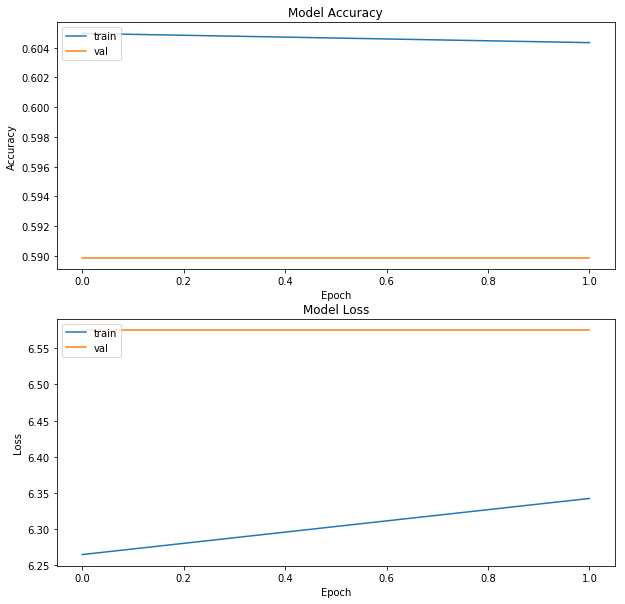

In [11]:
plt.figure(1, figsize=(10,10))  

# summarize history for accuracy  

plt.subplot(211)  
plt.plot(History.history['acc'])  
plt.plot(History.history['val_acc'])  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'val'], loc='upper left')  

# summarize history for loss  

plt.subplot(212)  
plt.plot(History.history['loss'])  
plt.plot(History.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'val'], loc='upper left')  
plt.show()

In [12]:
History.history

{'val_loss': [6.574980439749792, 6.574980439749792],
 'val_acc': [0.5898389096892308, 0.5898389096892308],
 'loss': [6.265072364511416, 6.34250707448915],
 'acc': [0.6049612402361493, 0.604341085326764]}

In [25]:
# Classification Report
y_true = np.argmax(test_targets, axis=1)
print(classification_report(y_true, predictions, target_names=labels))

C:\Users\micka\Anaconda3\envs\tensorflow-sessions\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

     Finding       0.00      0.00      0.00       638
  No Finding       0.34      1.00      0.51       329

   micro avg       0.34      0.34      0.34       967
   macro avg       0.17      0.50      0.25       967
weighted avg       0.12      0.34      0.17       967



In [23]:
test_targets

['Finding', 'No Finding']